In [1]:
import os
import json
import importlib

import glob as gb
import utils as ut
import numpy as np
import pandas as pd
import seaborn as sns

import ipywidgets as pyw
import matplotlib.pyplot as plt

# Global

In [2]:
%matplotlib inline

In [3]:
importlib.reload(ut)

plt.rcParams['text.usetex'] = True
plt.style.use(['dark_background'])

# Data

In [4]:
# load data
data = ut.load_data(os.path.join('data', 'v6', 'forest-00', '*.zip'))

extract /tmp/tmpskojpo2q/AOS-Simulation-Test-10
extract /tmp/tmpskojpo2q/AOS-Simulation-Test-50


In [5]:
# simulation
index = 1
simulation = list(data.keys())[index]

print('simulations:\n', '\n '.join([f'{i}: ' + (f'{x} [x]' if x == simulation else x) for i, x in enumerate(list(data.keys()))]))

simulations:
 0: AOS-Simulation-Test-10
 1: AOS-Simulation-Test-50 [x]


In [6]:
# load images
df = data[simulation]['images']
df = df[df['type'] == 'monochrome']
df = df.reset_index(drop=True)

print('images:', df.shape[0])

images: 309


In [7]:
# load parameters
parameters = data[simulation]['parameters']
parameters['images'] = df.shape[0]

print('\nparameters:', json.dumps(parameters, indent=4))


parameters: {
    "speed": 4,
    "height": 35,
    "coverage": 32.6415360708499,
    "view": 50,
    "images": 309,
    "sampling": 1,
    "resolution": 512,
    "type": "monochrome",
    "preset": "forest-05",
    "size": 1500,
    "ground": 70,
    "color": 16777215
}


# Plots

In [ ]:
fig, ax = plt.subplots(figsize=(16, 16))

# plot stage image
ut.plot_image(ax, data[simulation]['stage'], 'stage')

# plot sample images
ut.plot_images(df['data'], df['name'])

In [ ]:
df_integrate = df[:18]

# integrate images
integrated = ut.integrate_image(df_integrate, parameters, N=30)

# grayscale images
grayscaled = np.array([ut.grayscale_image(x) for x in df_integrate['data']])

In [ ]:
image_vs_integrated = np.hstack([grayscaled, integrated]).reshape(integrated.shape * np.array([2, 1, 1]))
image_vs_integrated_labels = np.dstack([df_integrate['name'], df_integrate['name'] + '-integral']).flatten()

# plot integrated images
ut.plot_images(image_vs_integrated, image_vs_integrated_labels, rows=6, cols=6)

In [49]:
importlib.reload(ut)

# integrate ground
ground, alphas = ut.integrate_ground(df, parameters)

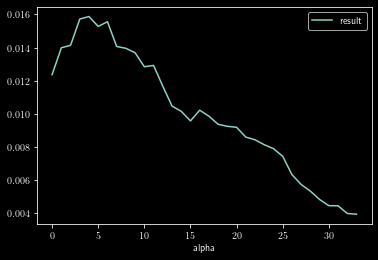

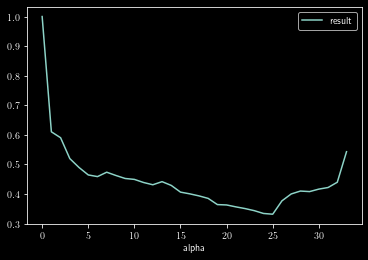

In [57]:
from sklearn.preprocessing import MinMaxScaler

scanned = 0
visible = 1

# ---------- DEBUG ----------
def dataframe_alphas(alphas, idx):
    # visible_ground_idx = np.nonzero(ground[:, :, 1])

    visible_alphas_idx = np.nonzero(alphas[:, :, idx])
    visible_alphas_idx_x, visible_alphas_idx_y, visible_alphas_idx_a = visible_alphas_idx

    scanned_alphas = alphas[visible_alphas_idx_x, visible_alphas_idx_y, 0, visible_alphas_idx_a]
    visible_alphas = alphas[visible_alphas_idx_x, visible_alphas_idx_y, 1, visible_alphas_idx_a]

    # alphas data
    data_alphas = np.array([visible_alphas_idx_a, scanned_alphas, visible_alphas, visible_alphas / scanned_alphas]).T

    # alphas dataframe
    df_alphas = pd.DataFrame(data_alphas, columns=['alpha', 'scanned', 'visible', 'ratio'])
    df_alphas = df_alphas.apply(pd.to_numeric, downcast='integer')
    
    return df_alphas

def scale(series):
    return MinMaxScaler().fit_transform(series.to_numpy().reshape(-1, 1))

def plot_alphas(df_alphas, columns):
    df_alphas_agg = df_alphas.groupby('alpha').sum()
    
    # df_alphas_agg['scanned'] = scale(df_alphas_agg['scanned'])
    # df_alphas_agg['visible'] = scale(df_alphas_agg['visible'])

    df_alphas_agg['result'] = df_alphas_agg['visible'] / df_alphas_agg['scanned']
    df_alphas_agg.plot(y=columns)

plot_alphas(dataframe_alphas(alphas, scanned), ['result'])
plot_alphas(dataframe_alphas(alphas, visible), ['result'])

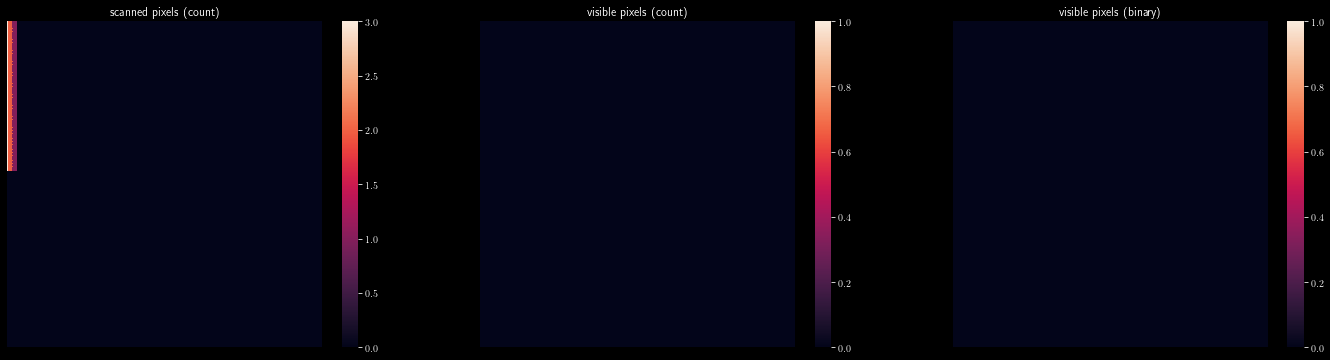

In [63]:
fig, axs = plt.subplots(1, 3, figsize=(24, 6))

# plot ground images
ut.plot_heatmap(axs[0], ground[:, :, 0], 'scanned pixels (count)')
ut.plot_heatmap(axs[1], ground[:, :, 1], 'visible pixels (count)')
ut.plot_heatmap(axs[2], ut.normalize_image(ground[:, :, 1] > 0), 'visible pixels (binary)')

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

# alpha dataframe
df_alpha = pd.DataFrame(alphas.T, columns=['visible_x', 'visible_y', 'camera_x', 'camera_y', 'alpha'])
df_alpha = df_alpha.sort_values(['visible_x', 'visible_y'], ignore_index=True)
df_alpha = df_alpha.sample(n=np.minimum(df_alpha.shape[0], 10**5), random_state=42)
df_alpha = df_alpha.apply(pd.to_numeric, downcast='integer')

# plot alpha distribution (sampled)
ut.plot_histogram(ax, df_alpha, 'alpha', f'field of view {parameters["view"]}°')

In [ ]:
scanned = np.count_nonzero(ground[:, :, 0])
captured = np.count_nonzero(ground[:, :, 1])
density = 1 - captured / scanned
mean = 1 - (ground[:, :, 1] > 0).mean()

print('density:', density)
print('mean:', mean)